# Setup and Data Loading

## 1.1 Importing Libraries
----------------------

Essential Libraries:

- Conv2D: Feature extraction through convolutional operations
- BatchNormalization: Stabilizes and accelerates training
- ImageDataGenerator: Real-time data augmentation
- ReduceLROnPlateau: Adaptive learning rate adjustment
- plot_model: Visual representation of network architecture


In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import (
    Input,Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D,
    Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
)
from tensorflow.keras.utils import to_categorical, plot_model

## 1.2 Loading Dataset
----------------------
Dataset Structure:
- 50,000 training + 10,000 test images
- 32x32 RGB images across 10 classes
- Classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
CLASS_NAMES = {
    0: 'airplane', 1: 'automobile', 2: 'bird',
    3: 'cat', 4: 'deer', 5: 'dog',
    6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}
BATCH_SIZE = 128
EPOCHS = 10

# Data Preprocessing

## 2.1 Preprocessing Data

In [4]:
# Normalize pixel values [0,1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# Convert labels to one-hot vectors
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Spilitting training Data for validation

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    random_state=42
)

## 2.2 Data Augmentation
-----
Augmentation Benefits:
- Increases effective dataset size
- Improves model generalization
- Reduces overfitting risk


In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)


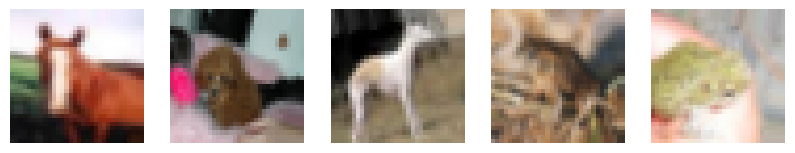

In [7]:
# Displaying augmented images
augmented_images = train_generator
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[0][0][i])
    plt.axis('off')

# Model Design

## 3.1 Designing model Architecture
------
Architecture Strategy:
- Progressive increase in filters (32 → 64)
- Alternating Conv and Pool layers for hierarchical feature learning
- BatchNorm after each Conv layer for stable training
- Increasing dropout rates for deeper layers

In [8]:
# Define the model
model = Sequential([
    Input(shape=(32,32,3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


## 3.2 Model Summary
------
- Displaying layer-wise parameter counts

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,746 (409.16 KB)

 Trainable params: 104,362 (407.66 KB)

 Non-trainable params: 384 (1.50 KB)

## 3.3 Optimization and Loss Function
------
- ADAM --> Adaptive learning rate optimizer
- Categorical CrossEntropy --> Multi-class classification

In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 3.4 Callbacks:
-----
- Automatically reduces learning rate when plateau detected
- Prevents oscillation in final training stages
- Allows finer weight adjustments near optima

In [11]:
# Learning Rate Scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Model Training and Evaluation

## 4.1 Train the model
-------
Training Parameters:
- Batch size 64: Balance between speed and stability
- 50 epochs: Sufficient for convergence without overfitting
- Validation on test set: Monitor generalization performance
- Data augmentation flow: Generate new variants in real-time

In [15]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 266s 851ms/step - accuracy: 0.4072 - loss: 1.6910 - val_accuracy: 0.1065 - val_loss: 3.5744 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 245s 783ms/step - accuracy: 0.5297 - loss: 1.3720 - val_accuracy: 0.5668 - val_loss: 1.2484 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 250s 744ms/step - accuracy: 0.5939 - loss: 1.2122 - val_accuracy: 0.5321 - val_loss: 1.3608 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 277s 792ms/step - accuracy: 0.6196 - loss: 1.1300 - val_accuracy: 0.5062 - val_loss: 1.5084 - learning_rate: 0.0010
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 246s 785ms/step - accuracy: 0.6358 - loss: 1.0642 - val_accuracy: 0.5602 - val_loss: 1.3536 - learning_rate: 0.0010
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 238s 760ms/step - accuracy: 0.6522 - loss: 1.0315 - val_accuracy: 0.5972 - val_loss: 1.2312 - learning_rate: 0.0010
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 245s 783ms/step - accura

## 4.2 Evaluation of Model Performance

In [16]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.7068
Test Loss: 0.8744


# Plotting Performance and Architecture
------
Interpretation Guide:
- Ideal Scenario: Training and validation curves stay close
- Overfitting Sign: Validation metrics plateau/diverges while training improves
- Underfitting Sign: Both metrics show poor performance
- Optimal Stopping: When validation loss stops improving

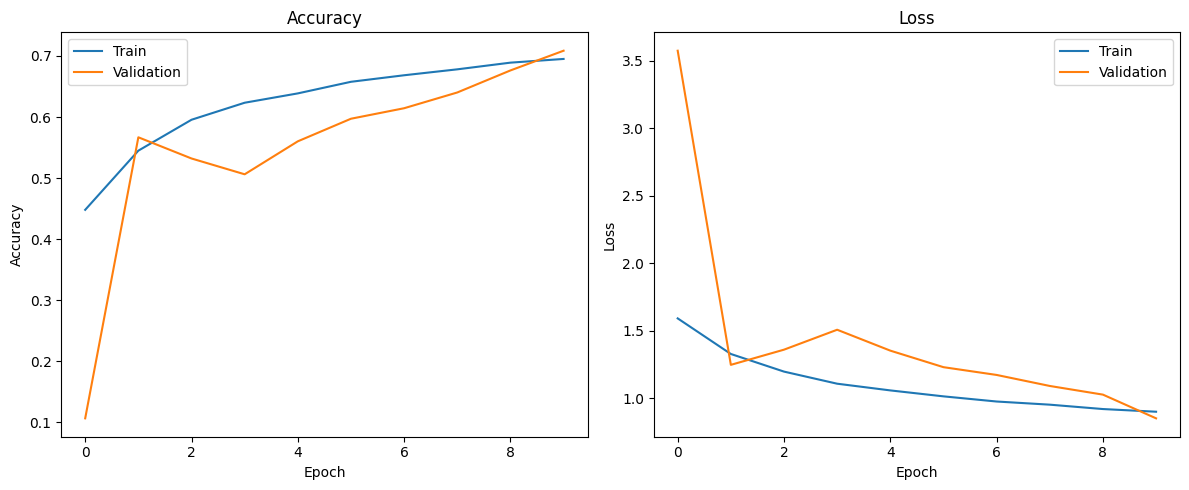

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout();

## Classification Report

In [18]:
y_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES.values()))

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.75      0.74      1000
  automobile       0.86      0.85      0.85      1000
        bird       0.70      0.48      0.57      1000
         cat       0.72      0.33      0.45      1000
        deer       0.47      0.85      0.61      1000
         dog       0.78      0.52      0.62      1000
        frog       0.68      0.81      0.74      1000
       horse       0.68      0.80      0.74      1000
        ship       0.86      0.82      0.84      1000
       truck       0.82      0.86      0.84      1000

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.70     10000
weighted avg       0.73      0.71      0.70     10000



## Confusion Matrix

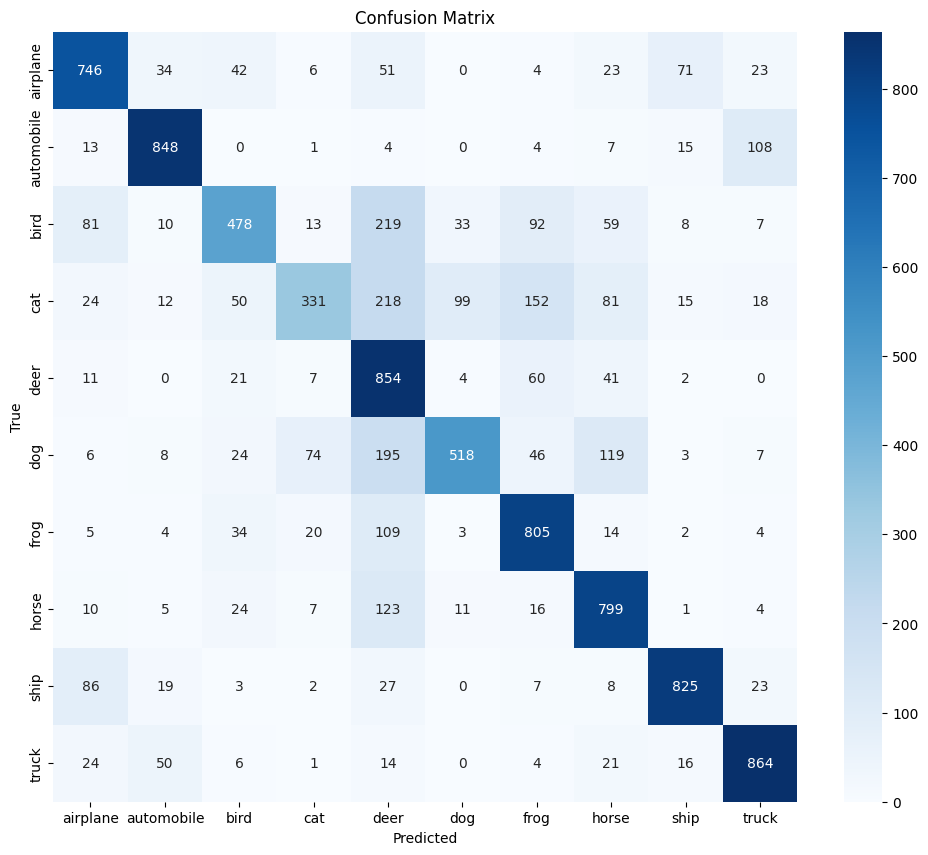

In [19]:
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES.values(),
            yticklabels=CLASS_NAMES.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix.png')

## Model Architecture

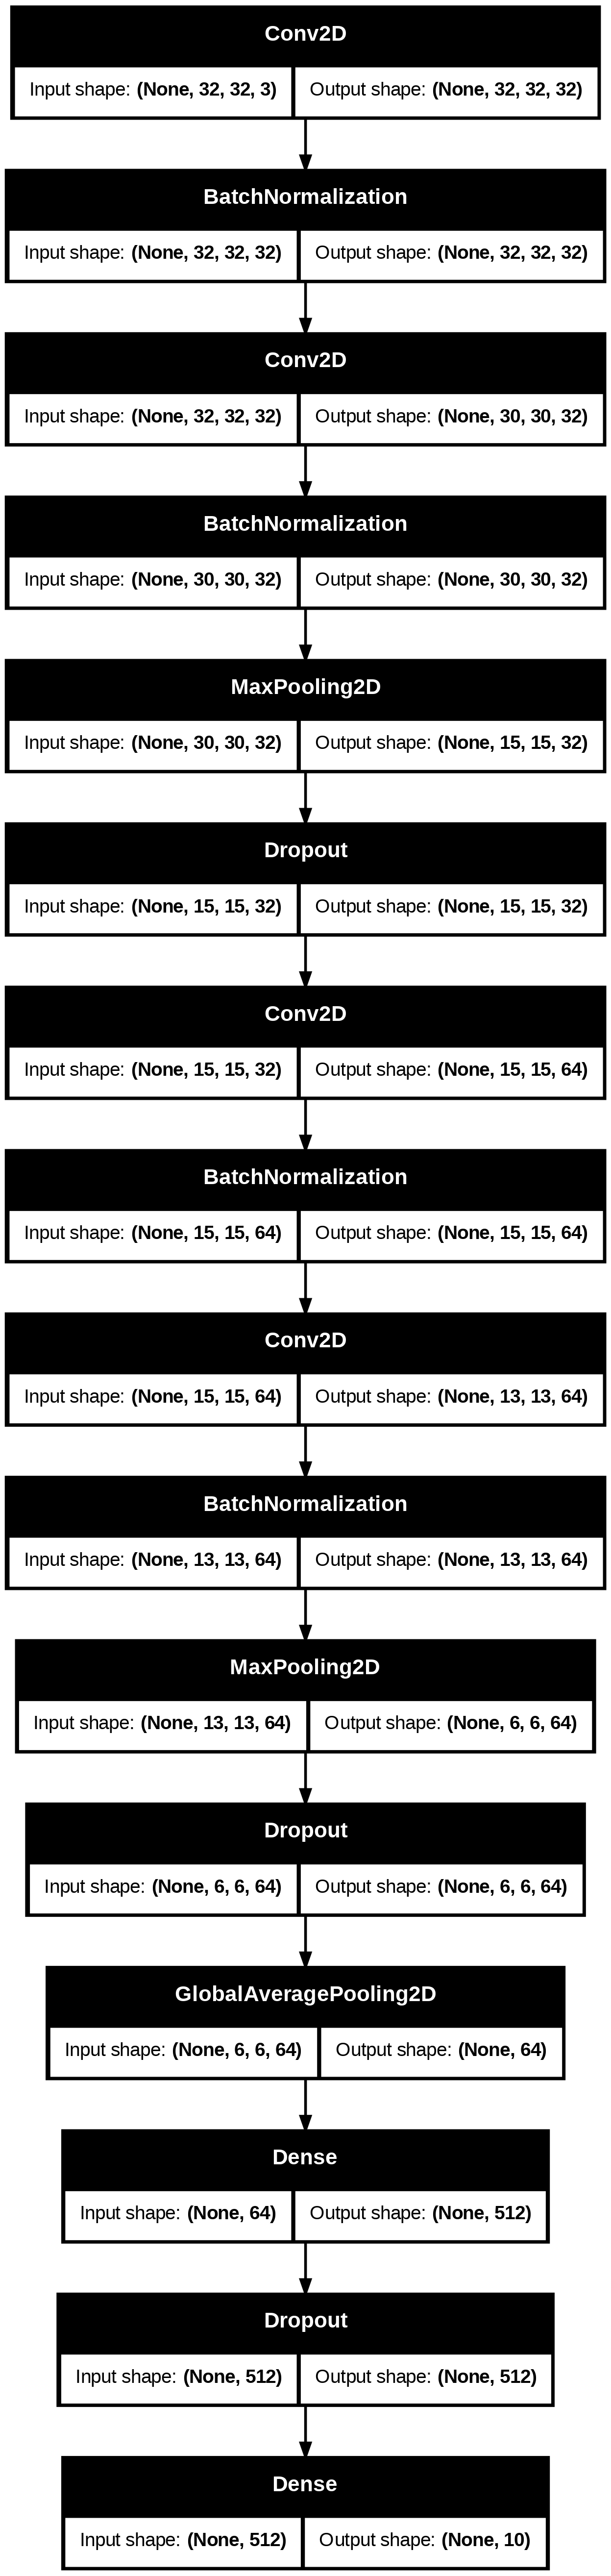

In [20]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Model Presistance
----------
- Saving model for future use/Deployment

In [21]:
save_model(model, 'final_model.keras')